<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import torch 
import torch.nn.functional as F
from torch import nn
import scipy.io as io
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from torch.optim import SGD, Adam
from torch.utils import data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Using TensorFlow backend.


In [2]:
train_snr = 15
M=16
NN_T = 64
NN_R=512

In [3]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(M, NN_T)  # 6*6 from image dimension
        self.fc2 = nn.Linear(NN_T, NN_T)
        self.fc3 = nn.Linear(NN_T, 8)
        
    def forward(self, in_message):
        x = F.relu(self.fc1(in_message))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        transmitted = x / torch.sqrt(2*torch.mean(x**2))
        return transmitted
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(4+4, NN_R)
        self.fc2 = nn.Linear(NN_R, NN_R)
        self.fc3 = nn.Linear(NN_R, NN_R)
        self.fc4 = nn.Linear(NN_R, M)
    def forward(self, in_message, in_channel):
        nn_input = torch.cat([in_message,in_channel],-1)
        x = F.relu(self.fc1(nn_input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        decoded = F.log_softmax(self.fc4(x), dim=-1)
        return decoded
        

In [4]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)


criterion= nn.NLLLoss()
opt = Adam(list(encoder.parameters())+list(decoder.parameters()), lr=0.001)

In [5]:
loss = np.array([])
batch = 200000
# batch = 2000

csi_real_set = torch.randn((M*batch, 2,1))/np.sqrt(2)
csi_imag_set = torch.randn((M*batch, 2,1))/np.sqrt(2)

data_set = data.TensorDataset(csi_real_set, csi_imag_set)
training_generator = data.DataLoader(data_set, batch_size=2048, shuffle=True, num_workers=4)

for epoches in np.arange(20):
    print('epoch =', epoches)
    for ch_real, ch_imag in training_generator:
        csi_real = ch_real.to(device)
        csi_imag = ch_imag.to(device)
        
        messages = np.random.randint(0,M, csi_real.shape[0])
        
        train_data = torch.from_numpy(to_categorical(messages)).to(device)
        train_label = torch.from_numpy(messages).long().to(device)
        

        transmitted =encoder(train_data)
        tx_real = transmitted[:, np.arange(0,4)].view(-1,2,2)
        tx_imag = transmitted[:, np.arange(4,8)].view(-1,2,2)
        
        rx_real = torch.bmm(tx_real, csi_real) - torch.bmm(tx_imag, csi_imag)
        rx_imag = torch.bmm(tx_real, csi_imag) + torch.bmm(tx_imag, csi_real)
        
        rx = torch.cat([rx_real, rx_imag], axis=-2).view(-1,4)
      
        sigma = np.sqrt(0.5/(np.power(10, train_snr/10)))
        noise = (sigma * torch.randn(rx.shape)).to(device)
        rx = rx + noise
        
        csi = torch.cat([csi_real, csi_imag], axis=-2).view(-1,4)
        
        y_pred = decoder(rx, csi)
        cross_entropy = criterion(y_pred, train_label)
        
        opt.zero_grad()
       
        cross_entropy.backward()
        opt.step()
      

    l = cross_entropy.to('cpu').detach().numpy()
    loss = np.append(loss, l)
    
        
        
        
        
        

epoch = 0
epoch = 1
epoch = 2
epoch = 3
epoch = 4
epoch = 5
epoch = 6
epoch = 7
epoch = 8
epoch = 9
epoch = 10
epoch = 11
epoch = 12
epoch = 13
epoch = 14
epoch = 15
epoch = 16
epoch = 17
epoch = 18
epoch = 19


(20,)
[0.0080555  0.00811348 0.00817146 0.00822944 0.00828741 0.00834539
 0.00791129 0.00771348 0.00752331 0.00786079 0.00731485 0.00845758
 0.00812069 0.00697618 0.00695291 0.00674387 0.00653484 0.0063258
 0.00611677 0.00590773]
(20,)


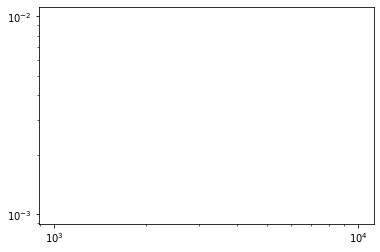

In [6]:
print(loss.shape)
from scipy.ndimage.filters import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter 
import tikzplotlib


qqq = loss


# plt.figure()
# plt.loglog(loss)

aaa = np.array(savgol_filter(qqq,11,1))
print(aaa)
print(aaa.shape)

x = np.arange(1,aaa.shape[0]+1)*1024

data = np.concatenate([x.reshape(-1,1), aaa.reshape(-1,1)], -1)

np.savetxt('open_loss.txt', data[::100,:])

plt.loglog(data[::100,0],data[::100,1])
import tikzplotlib
tikzplotlib.save("open_loss.tex")

In [7]:
# checkpoint = torch.load('Autoencoder-alamouti-torch-model')
# encoder.load_state_dict(checkpoint['encoder'])
# decoder.load_state_dict(checkpoint['decoder'])
# # tx_opt.load_state_dict(checkpoint['tx_opt'])
# # rx_opt.load_state_dict(checkpoint['rx_opt'])

In [8]:



SER = np.array([])
with torch.no_grad():
    for test_snr in np.arange(0,26,2):
        ser_temp = np.array([])
        for temp in np.arange(100):
            batch = 40
            messages = np.arange(M)
            messages = np.tile(messages, batch)
            test_labels = to_categorical(messages)

            csi_real = (torch.randn((M*batch, 2,1))/np.sqrt(2)).to(device)
            csi_imag = (torch.randn((M*batch, 2,1))/np.sqrt(2)).to(device)


            test_data = torch.from_numpy(test_labels).to(device)
            test_label = torch.from_numpy(messages).to(device)

            transmitted =encoder(test_data)
            tx_real = transmitted[:, np.arange(0,4)].view(-1,2,2)
            tx_imag = transmitted[:, np.arange(4,8)].view(-1,2,2)

            rx_real = torch.bmm(tx_real, csi_real) - torch.bmm(tx_imag, csi_imag)
            rx_imag = torch.bmm(tx_real, csi_imag) + torch.bmm(tx_imag, csi_real)

            rx = torch.cat([rx_real, rx_imag], axis=-2).view(-1,4)


            sigma = np.sqrt(0.5/(np.power(10, test_snr/10)))
            noise = (sigma * torch.randn(rx.shape)).to(device)
            rx = rx + noise

            csi = torch.cat([csi_real, csi_imag], axis=-2).view(-1,4)

            y_pred = decoder(rx, csi)

            classification = torch.argmax(y_pred, axis=-1).to('cpu').detach().numpy()

            correct = np.equal(classification , messages)


            ser = 1- np.mean(correct)

            ser_temp = np.append(ser_temp, ser)
        ser_ave = np.mean(ser_temp)



        SER = np.append(SER ,ser_ave)
    


        
        
        

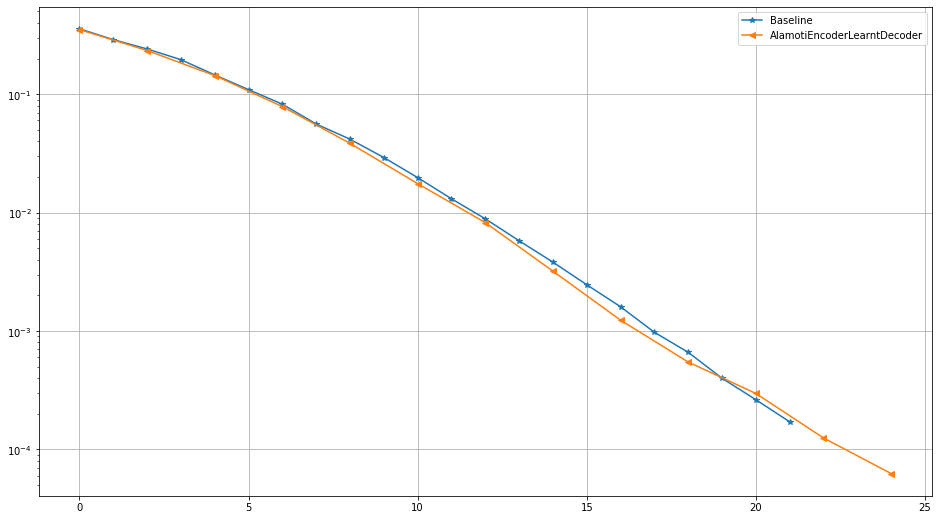

In [9]:
data = io.loadmat('baseline/Alamouti_SER_theory-4QAM.mat')

base_line = np.array(data['ser'])

plt.figure(figsize=(16,9))

pl1, pl2 = plt.semilogy(np.arange(0,22), base_line[0,0:22], '-*',
                           np.arange(0,26,2), SER, '-<')
# , SNR_array, SER, '-o'
plt.grid()
plt.legend([pl1, pl2],['Baseline', 
                           'AlamotiEncoderLearntDecoder'])

[[3.5700e-01 2.8920e-01 2.4130e-01 1.9580e-01 1.4550e-01 1.0940e-01
  8.2400e-02 5.6000e-02 4.1700e-02 2.9200e-02 1.9756e-02 1.3086e-02
  8.8660e-03 5.7840e-03 3.8160e-03 2.4580e-03 1.6020e-03 9.7500e-04
  6.6100e-04 3.9900e-04 2.6300e-04 1.7100e-04 9.8000e-05 5.0000e-05
  4.8000e-05 2.4000e-05]]


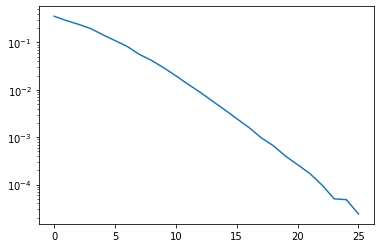

In [10]:
data = io.loadmat('baseline/Alamouti_SER_theory-4QAM.mat')

base_line = np.array(data['ser'])
print(base_line)
plt.semilogy(np.arange(26), base_line[0,:])

In [11]:
# torch.save({
#             'encoder': encoder.state_dict(),
#             'decoder': decoder.state_dict(),
#             'opt': opt.state_dict(),
            
#             }, 'Autoencoder-alamouti-torch-model')


In [12]:
print(SER)

[3.51343750e-01 2.34046875e-01 1.43843750e-01 7.86406250e-02
 3.84531250e-02 1.75781250e-02 8.23437500e-03 3.20312500e-03
 1.23437500e-03 5.46875000e-04 2.96875000e-04 1.25000000e-04
 6.25000000e-05]


(6400, 8)


Text(0.5, 1.0, 'Tx sym, Ant 2, T2')

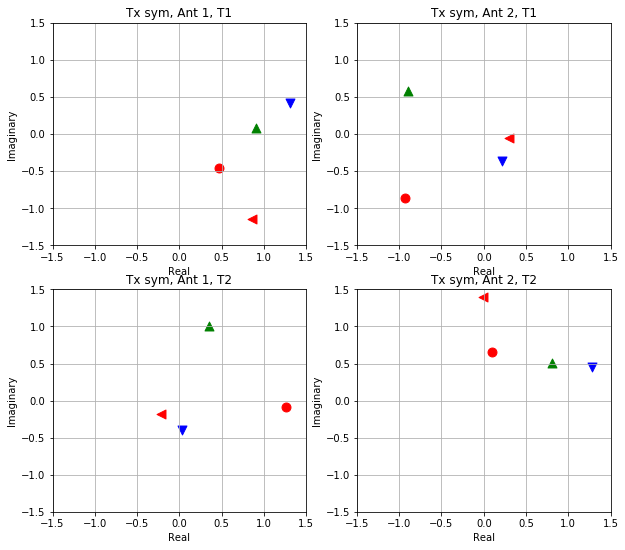

In [13]:
batch = 400
messages = np.arange(M)
messages = np.tile(messages, batch)
test_labels = to_categorical(messages)

csi_real = (torch.randn((M*batch, 2,1))/np.sqrt(2)).to(device)
csi_imag = (torch.randn((M*batch, 2,1))/np.sqrt(2)).to(device)


test_data = torch.from_numpy(test_labels).to(device)
test_label = torch.from_numpy(messages).to(device)

transmitted_signals =encoder(test_data).to('cpu').detach().numpy()

    
print(transmitted_signals.shape)   

fig, axs = plt.subplots(2, 2, figsize=(10,9))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]
for axe in [ax1, ax2, ax3, ax4]:
    axe.grid(True)
    axe.set_xlim([-1.5, 1.5])
    axe.set_ylim([-1.5, 1.5])
    axe.set_xlabel('Real')
    axe.set_ylabel('Imaginary')


color_map = ['r', 'b', 'g','r','c', 'm','y','k','w','r', 'b', 'g','r','c', 'm','y','k','w']
marker_style = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X','o']

for i in  np.arange(4):
    ax1.scatter(transmitted_signals[i,0], transmitted_signals[i,4], c=color_map[i], s=80, marker=marker_style[i])
    ax2.scatter(transmitted_signals[i,1], transmitted_signals[i,5], c=color_map[i], s=80, marker=marker_style[i])
    ax3.scatter(transmitted_signals[i,2], transmitted_signals[i,6], c=color_map[i], s=80, marker=marker_style[i])
    ax4.scatter(transmitted_signals[i,3], transmitted_signals[i,7], c=color_map[i], s=80, marker=marker_style[i])



ax1.set_title('Tx sym, Ant 1, T1')
ax2.set_title('Tx sym, Ant 2, T1')
ax3.set_title('Tx sym, Ant 1, T2')
ax4.set_title('Tx sym, Ant 2, T2')
